# 01.01 - PROYECTO PHISHING EMAILS ML

# 1. Introducción y configuración inicial

**Integrantes**

- Estiven Ospina González
- María Daniela Rodríguez Chacón

**1.2 Importación de librerías**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone # Para clonar los modelos sin que compartan estado
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek as SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

**1.3. Carga de datos**


In [11]:
df = pd.read_csv("../Dataset/phishing_legit_dataset_KD_10000.csv", encoding="utf-8")

y = df['label']
X = df.drop(['label', 'phishing_type', 'severity', 'confidence'], axis=1)

print('Informacion del dataSet')
print(f"\nDimensió en variable de características 'X': {X.shape}\nDimensión en variable objetivo 'y': {y.shape}")
print(f"\nCantidad de clases en variable objetivo:{y.value_counts()}")
print(f"\nDistribución de clases:\n{y.value_counts(normalize=True)}")
print(f'\nInformación de características: {X.info()}')

Informacion del dataSet

Dimensió en variable de características 'X': (10000, 1)
Dimensión en variable objetivo 'y': (10000,)

Cantidad de clases en variable objetivo:label
1    6000
0    4000
Name: count, dtype: int64

Distribución de clases:
label
1    0.6
0    0.4
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB

Información de características: None


In [12]:
X.head()

,text
0,Subject: Office maintenance\n\nThanks for your...
1,"Hello, your profile has been locked. Use the s..."
2,"Hi there, congratulations! You are the winner ..."
3,"Attention, this is the fraud prevention accoun..."
4,"Notice, your profile has been restricted. Use ..."


# División de datos: entrenamiento, validación y prueba, y preprocesamiento de características

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X['text'],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
X_train_features = vectorizer.fit_transform(X_train_text)
X_test_features = vectorizer.transform(X_test_text)

print(f"Dimensiones de entrenamiento de TF-IDF: {X_train_features.shape}")
print(f"Dimensiones de prueba de TF-IDF: {X_test_features.shape}")
X_train_val = pd.DataFrame(X_train_features.toarray())
X_test = pd.DataFrame(X_test_features.toarray())

y_train_val = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Dimensiones de entrenamiento de TF-IDF: (8000, 20)
Dimensiones de prueba de TF-IDF: (2000, 20)


In [14]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['access' 'account' 'best' 'code' 'dear' 'desk' 'draft' 'follow'
 'keywords' 'link' 'meeting' 'notice' 'password' 'security' 'soon'
 'subject' 'team' 'thanks' 'today' 'verification']


# Preparación para modelos con sus respectivos hiperparámetros

In [15]:
# Diccionario de hiperparametros para cada modelo con sus respectivos parametros con
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models_params = {
  'Logistic Regression': {
    'model': LogisticRegression(random_state=42, max_iter=100),
    'param_grid': {
      'classifier__C': [0.01, 0.1, 1],
      'classifier__penalty': ['l1', 'l2'],
      'classifier__solver': ['liblinear']
    }
  },
  'K-Nearest Neighbors': {
    'model': KNeighborsClassifier(),
    'param_grid': {
      'classifier__n_neighbors': [3, 5, 9],
      'classifier__weights': ['uniform', 'distance'],
      'classifier__metric': ['euclidean', 'manhattan']
    }
  },
  'Random Forest': {
    'model': RandomForestClassifier(random_state=42),
    'param_grid': {
      'classifier__n_estimators': [10, 20, 50],
      'classifier__max_features': ['sqrt', 'log2'],
      'classifier__max_depth': [10, 20, 30],
      'classifier__min_samples_split': [2, 5]
    }
  },
  'MLP Classifier': {
    'model': MLPClassifier(random_state=42, max_iter=100),
    'param_grid': {
      'classifier__hidden_layer_sizes': [(64,), (64, 32)], # capa oculta
      'classifier__activation': ['relu', 'tanh'],
      'classifier__solver': ['adam'], # optimizacion
      'classifier__alpha': [0.0001, 0.001], # regularización
      'classifier__learning_rate_init': [0.001, 0.01]
    }
  },
  'Gradient Boosting': {
    'model': GradientBoostingClassifier(random_state=42),
    'param_grid': {
      'classifier__n_estimators': [10, 50],
      'classifier__learning_rate': [0.01, 0.1],
      'classifier__max_depth': [3, 5],
      'classifier__subsample': [0.8, 1.0] # Fracción de muestras para cada árbol
    }
  },
  'Support Vector Machine': {
    'model': SVC(random_state=42, probability=True, max_iter=100),
    'param_grid': {
      'classifier__C': [0.1, 1],
      'classifier__kernel': ['linear'],
      'classifier__gamma': ['scale']
    }
  }
}


# Diccionarios y listas para almacenar resultados
mejor_estimaciones = {}        # diccionario del mejor pipeline entrenado para cada modelo
test_resultados = []           # lista de las metricas de desempeño con respecto al conjunto de prueba
grid_search_resultados = []    # lista de los resultados para cada modelo

In [16]:
# visualizar hiperparametros de cada modelo
data = []
for model_name, config in models_params.items():
    model_instance = config['model']
    param_grid_str = str(config['param_grid']) # Convertir el diccionario a string para una sola celda
    data.append([model_name, type(model_instance).__name__, param_grid_str])

df = pd.DataFrame(data, columns=['Nombre del Modelo', 'Clase del Modelo', 'Parámetros a Tunear (param_grid)'])

print(df.to_string(index=False))

     Nombre del Modelo           Clase del Modelo                                                                                                                                                                                         Parámetros a Tunear (param_grid)
   Logistic Regression         LogisticRegression                                                                                                              {'classifier__C': [0.01, 0.1, 1], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear']}
   K-Nearest Neighbors       KNeighborsClassifier                                                                                 {'classifier__n_neighbors': [3, 5, 9], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan']}
         Random Forest     RandomForestClassifier                                                 {'classifier__n_estimators': [10, 20, 50], 'classifier__max_features': ['sqrt', 'log2'], 'classifier_

# Entrenamiento y optimización de modelos

In [17]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # validacion cruzada en 5 partes

for model_, config in models_params.items():
  print(f"\nModelo: {model_}")
  # Con ImbPipeline indicamos el conjunto de pasos a ejecutar a la data de entrenamiento antes de su ejecucion
  pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', config['model'])
  ])

  # creamos el grid para hacer un entrenar a los modelos en condiciones similares
  grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=config['param_grid'], # lo hiperparametros mencionados
    cv=stratified_kfold, # validacion cruzada
    scoring='f1',       # usamos f1 como métrica de scoring principal debido al desbalance de clases
    n_jobs=-1,          # usar todos los núcleos disponibles para acelerar
    verbose=2,          # mostrar progreso
    return_train_score=True # necesario para analizar sobreajuste y obtener CIs
  )

  # Entrenamiento del modelo, guardado y visualizacion del mejor modelo entrenado
  grid_search.fit(X_train_val, y_train_val)
  mejor_estimaciones[model_] = grid_search.best_estimator_
  print(f"\n  Mejores parametros : {grid_search.best_params_}\n  Mejor f1-score de validacion: {grid_search.best_score_}")


  print(f"\nEvaluacion de {model_}:")
  y_pred = mejor_estimaciones[model_].predict(X_test)
  y_proba = mejor_estimaciones[model_].predict_proba(X_test)[:, 1] # Probabilidad de la clase sea 1

  # Calcular métricas de desempeño
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_proba)

  test_resultados.append({
    'Model': model_,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'Confusion Matrix': confusion_matrix(y_test, y_pred) # Almacenar la matriz directamente
  })

  print(f"\tAccuracy: {acc:.4f}\n\tPrecision: {prec:.4f}\n\tRecall: {rec:.4f}\n\tF1-Score: {f1:.4f}\n\tROC AUC: {roc_auc:.4f}")
  print(f"\tMatriz de Confusion:\n{confusion_matrix(y_test, y_pred)}")

  # Guardar todos los resultados para comparativas
  results_df = pd.DataFrame(grid_search.cv_results_)
  results_df['model_name'] = model_
  grid_search_resultados.append(results_df)

grid_search_results = pd.concat(grid_search_resultados, ignore_index=True) # Concatenar todos los resultados en un solo dataframe


Modelo: Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits

  Mejores parametros : {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
  Mejor f1-score de validacion: 1.0

Evaluacion de Logistic Regression:
	Accuracy: 1.0000
	Precision: 1.0000
	Recall: 1.0000
	F1-Score: 1.0000
	ROC AUC: 1.0000
	Matriz de Confusion:
[[ 800    0]
 [   0 1200]]

Modelo: K-Nearest Neighbors
Fitting 5 folds for each of 12 candidates, totalling 60 fits

  Mejores parametros : {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
  Mejor f1-score de validacion: 1.0

Evaluacion de K-Nearest Neighbors:
	Accuracy: 1.0000
	Precision: 1.0000
	Recall: 1.0000
	F1-Score: 1.0000
	ROC AUC: 1.0000
	Matriz de Confusion:
[[ 800    0]
 [   0 1200]]

Modelo: Random Forest
Fitting 5 folds for each of 36 candidates, totalling 180 fits

  Mejores parametros : {'classifier__max_depth': 10, 'classifier__max_features': 

# Análisis y visualización de resultados


Modelo Logistic Regression:

  Mejores hiperparametros para Logistic Regression:
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                                 1.0 ± 0.0                                  
           Prueba                                      1.0     1.0       1.0    1.0      1.0


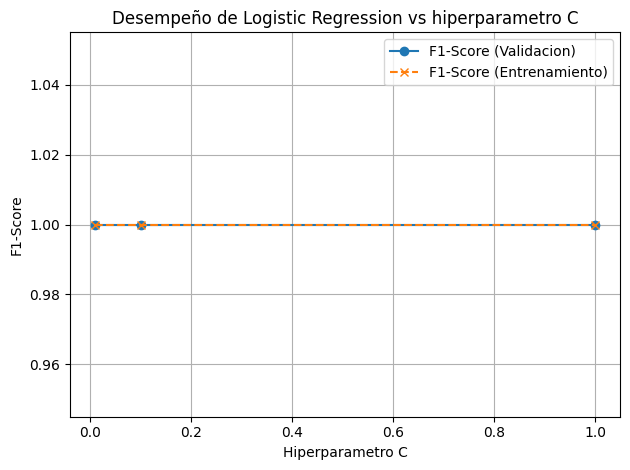

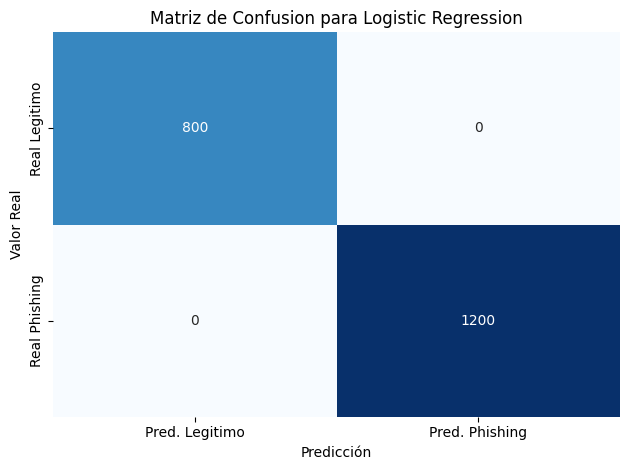

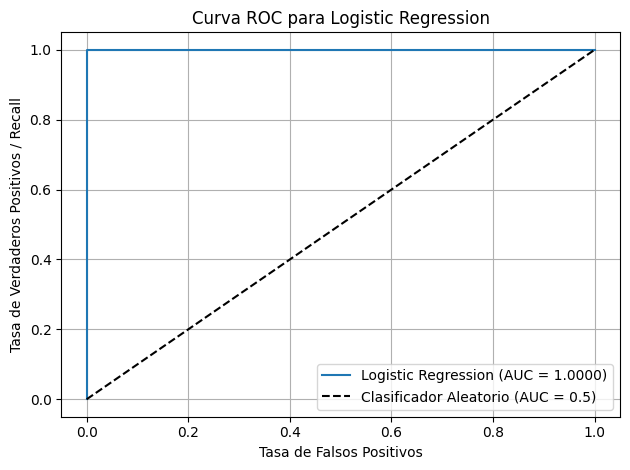


Modelo K-Nearest Neighbors:

  Mejores hiperparametros para K-Nearest Neighbors:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                                 1.0 ± 0.0                                  
           Prueba                                      1.0     1.0       1.0    1.0      1.0


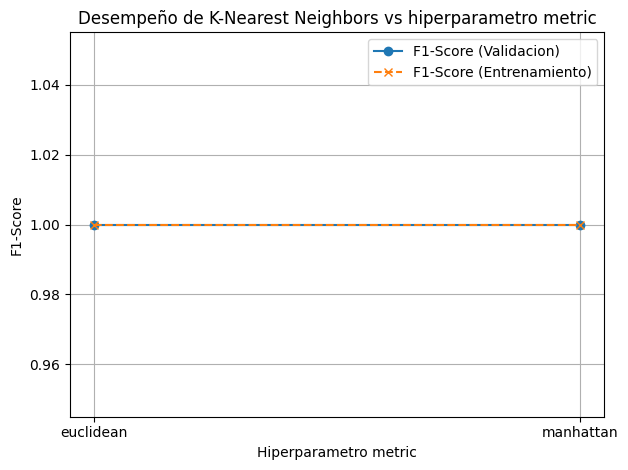

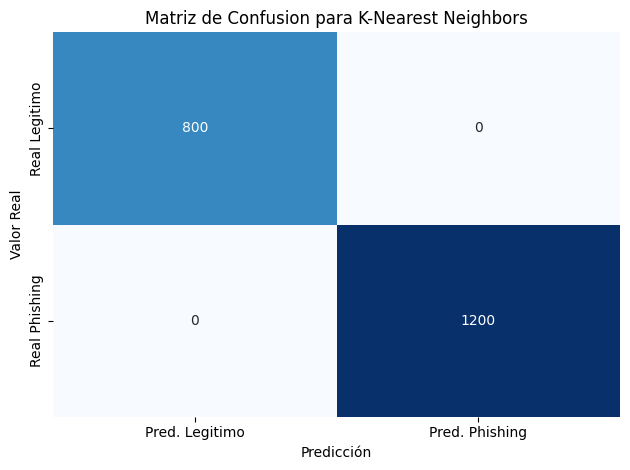

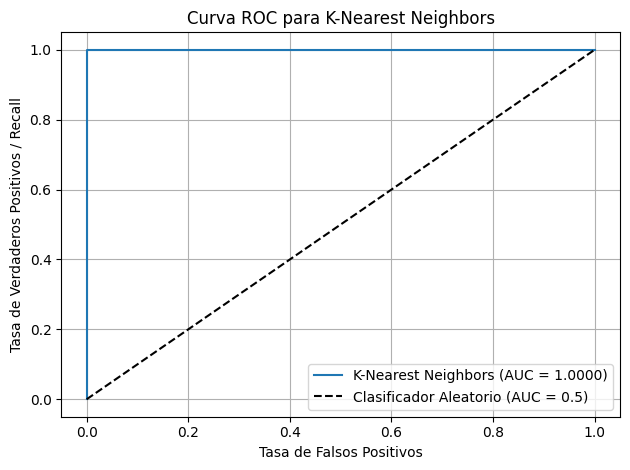


Modelo Random Forest:

  Mejores hiperparametros para Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                                 1.0 ± 0.0                                  
           Prueba                                      1.0     1.0       1.0    1.0      1.0


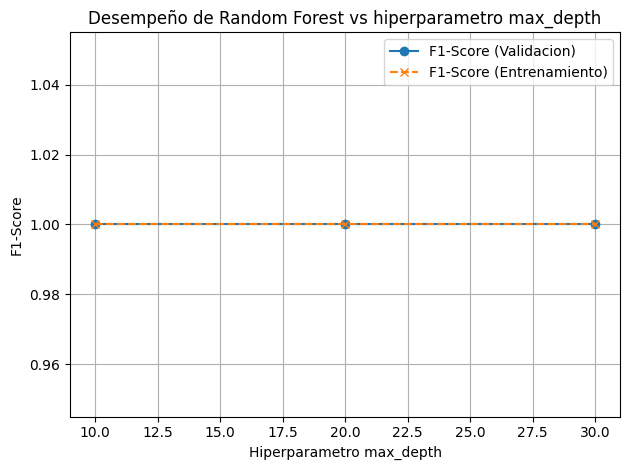

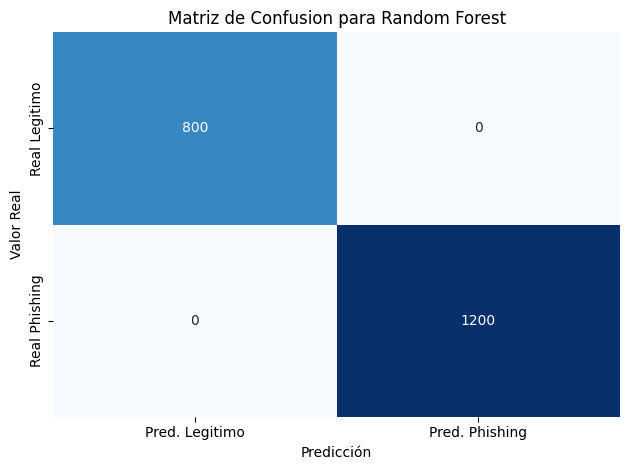

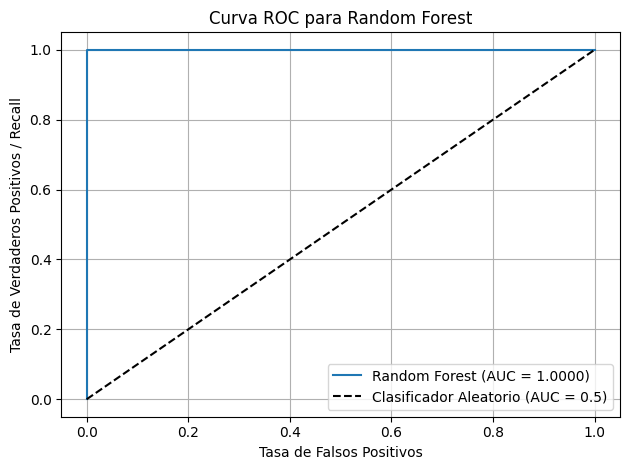


Modelo MLP Classifier:

  Mejores hiperparametros para MLP Classifier:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                                 1.0 ± 0.0                                  
           Prueba                                      1.0     1.0       1.0    1.0      1.0


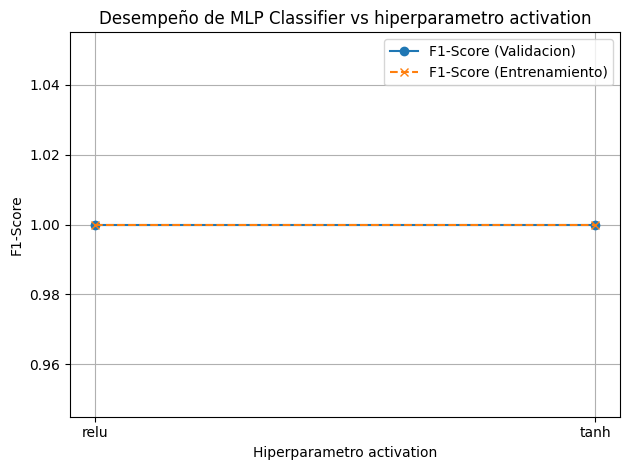

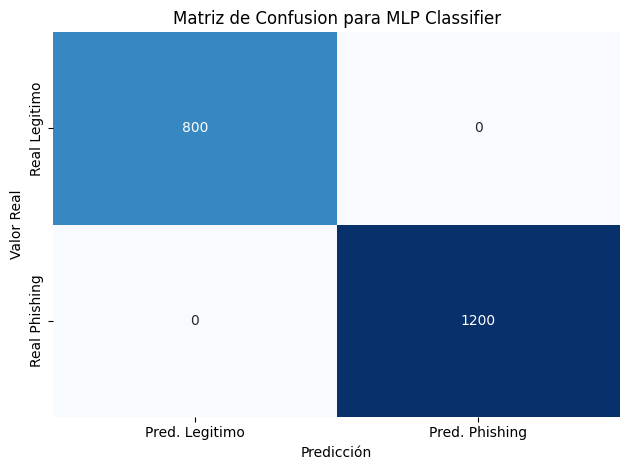

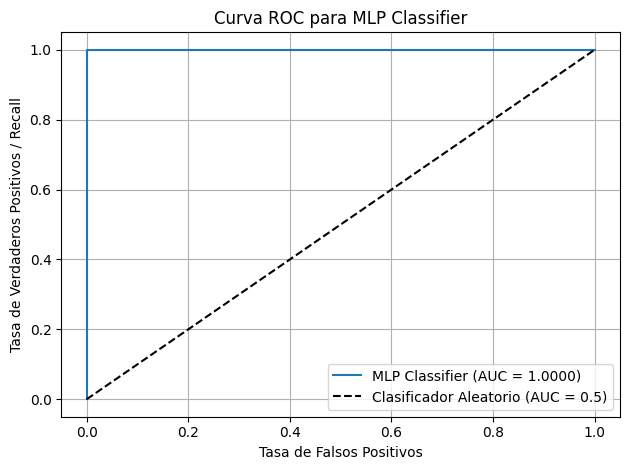


Modelo Gradient Boosting:

  Mejores hiperparametros para Gradient Boosting:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                                 1.0 ± 0.0                                  
           Prueba                                      1.0     1.0       1.0    1.0      1.0


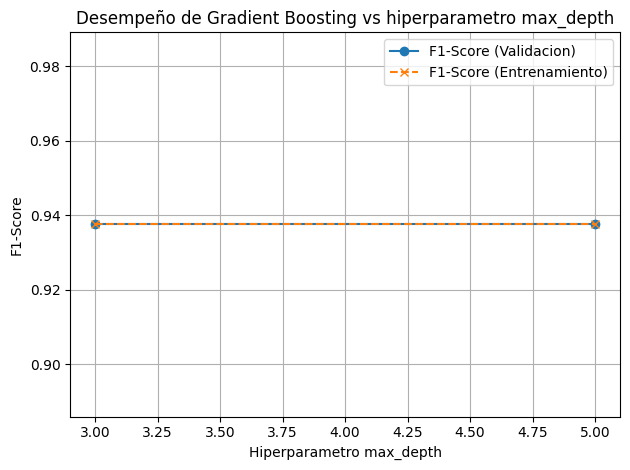

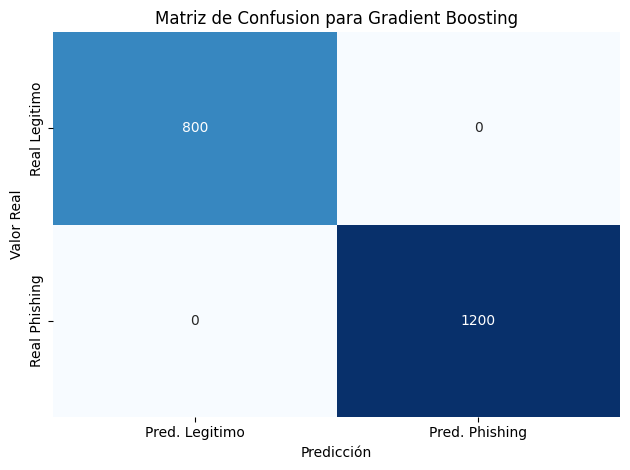

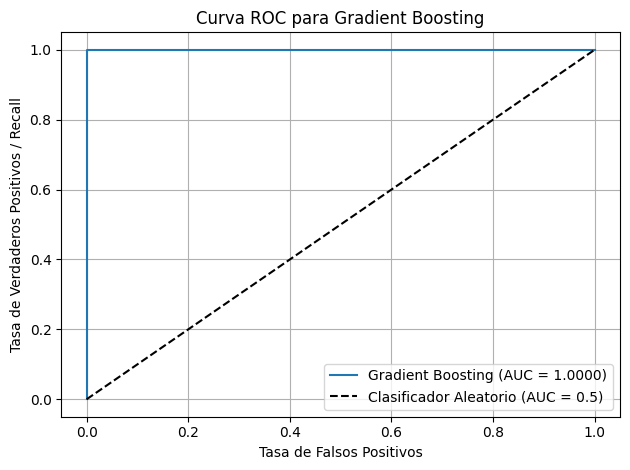


Modelo Support Vector Machine:

  Mejores hiperparametros para Support Vector Machine:
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 100, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                                 1.0 ± 0.0                                  
           Prueba                                      1.0     1.0       1.0    1.0      1.0


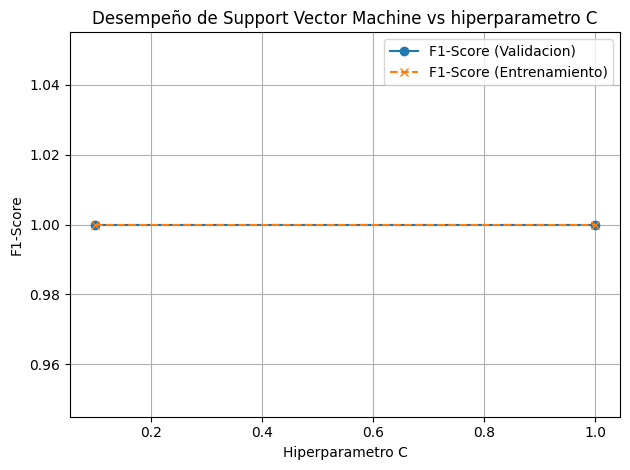

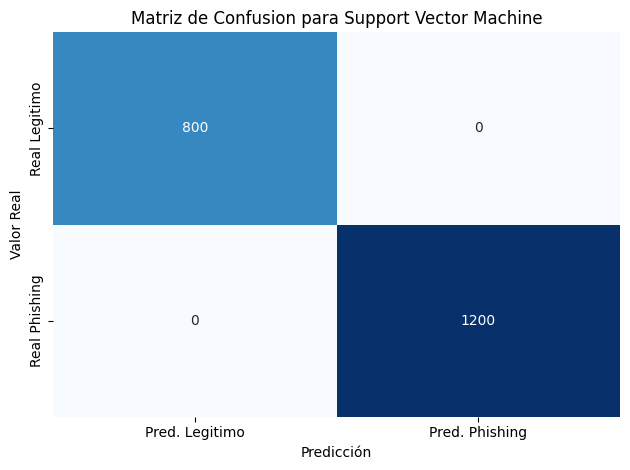

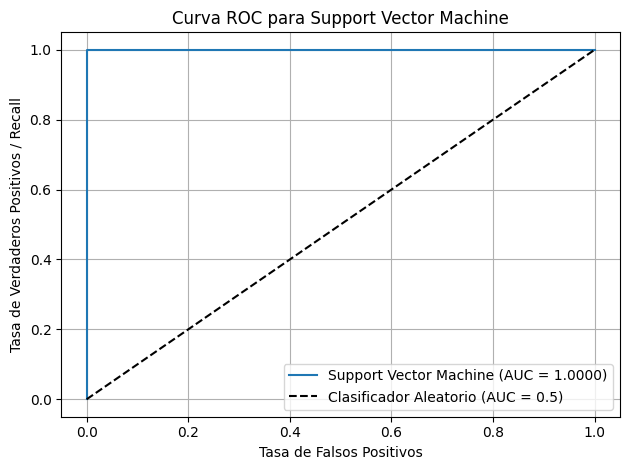


Tabla Comparativa de Modelos
                        Accuracy  Precision  Recall  F1-Score  ROC AUC
Model                                                                 
Logistic Regression          1.0        1.0     1.0       1.0      1.0
K-Nearest Neighbors          1.0        1.0     1.0       1.0      1.0
Random Forest                1.0        1.0     1.0       1.0      1.0
MLP Classifier               1.0        1.0     1.0       1.0      1.0
Gradient Boosting            1.0        1.0     1.0       1.0      1.0
Support Vector Machine       1.0        1.0     1.0       1.0      1.0


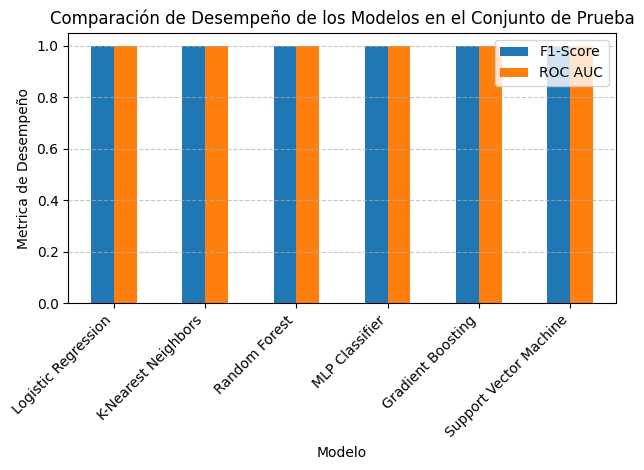

In [24]:
# Convertir resultados del test a dataframe para facilitar la visualización
test_resultado_df = pd.DataFrame(test_resultados).set_index('Model')

for model_name, config in models_params.items():
  # visualizar cada modelo
  print(f"\nModelo {model_name}:")
  best_estimator = mejor_estimaciones[model_name]

  # Mostrar los mejores hiperparámetros encontrados
  print(f"\n  Mejores hiperparametros para {model_name}:")
  print(best_estimator.named_steps['classifier'].get_params())


  # obtenemos resultados de validación cruzada para el mejor modelo
  mejor_idx_for_model = grid_search_results[
    (grid_search_results['rank_test_score'] == 1) &
    (grid_search_results['model_name'] == model_name)
  ].index[0]
  row_cv_results = grid_search_results.loc[mejor_idx_for_model]

  # Metricas de entrenamiento y validación
  # mean_score es el score f1-score de entrenamiento promedio de los folds para el mejor modelo
  train_f1_mean = row_cv_results['mean_train_score'] # media
  train_f1_std = row_cv_results['std_train_score'] # desviacion
  val_f1_mean = row_cv_results['mean_test_score'] # media
  val_f1_std = row_cv_results['std_test_score'] # desviacion

  # Desempeño en Test
  test_data_row = test_resultado_df.loc[model_name]
  performance_table = pd.DataFrame({
    'Conjunto de Datos': ['Entrenamiento ' , 'Validación ', 'Prueba'],
    'F1-Score (promedio ± desviacion / valor)': [
      f"{train_f1_mean:.4} ± {train_f1_std:.4}",
      f"{val_f1_mean:.4} ± {val_f1_std:.4}",
      f"{test_data_row['F1-Score']:.4}"
    ],
    'ROC AUC': [
      "", # no guardamos la metricas anteriores por lo que solamente podremos visualizar los scores principales
      "",
      f"{test_data_row['ROC AUC']:.4}"
    ],
    'Precisión': [
      "",
      "",
      f"{test_data_row['Precision']:.4}"
    ],
    'Recall': [
      "",
      "",
      f"{test_data_row['Recall']:.4}"
    ],
    'Accuracy': [
      "",
      "",
      f"{test_data_row['Accuracy']:.4}"
    ]
  })
  print("\nTabla de desempeño del modelo usando validacion cruzada:")
  print(performance_table.to_string(index=False))

  # identificamos el hiperparametro mas imprtante para cada modelo con el objetivo de a hacer un visualizacion
  resultado_plot = grid_search_results[grid_search_results['model_name'] == model_name].sort_values(by='mean_test_score', ascending=False).copy()
  hiperparametros_names = [col for col in resultado_plot.columns if col.startswith('param_classifier__')]

  # Elegir el primer parámetro que tenga más de un valor único para graficar
  plot_param_name = None
  for p_name in hiperparametros_names:
    # transformamos la tubla para que sea un variable
    if resultado_plot[p_name].nunique() > 1 and not (isinstance(resultado_plot[p_name].iloc[0], tuple) and resultado_plot[p_name].nunique() > 1):
      plot_param_name = p_name
      break

  clean_plot_param_name = plot_param_name.replace('param_classifier__', '')

  # Agrupar por el parámetro para graficar promedios
  plot_df = resultado_plot.groupby(plot_param_name).agg(
    mean_test_score=('mean_test_score', 'mean'),
    mean_train_score=('mean_train_score', 'mean')
  ).reset_index()

  # convertir a cadena si es un tipo numericos o booleano para el eje X
  x_values = plot_df[plot_param_name].apply(lambda x: str(x)) if plot_df[plot_param_name].dtype == 'object' or pd.api.types.is_bool_dtype(plot_df[plot_param_name]) else plot_df[plot_param_name]

  # ordenar x_values si son numericos para una grafica coherente
  if not (plot_df[plot_param_name].dtype == 'object' or pd.api.types.is_bool_dtype(plot_df[plot_param_name])):
    plot_df = plot_df.sort_values(by=plot_param_name)
    x_values = plot_df[plot_param_name]

  # visualizacion de desempeño del modelo
  plt.plot(x_values, plot_df['mean_test_score'], marker='o', label='F1-Score (Validacion)')
  plt.plot(x_values, plot_df['mean_train_score'], marker='x', linestyle='--', label='F1-Score (Entrenamiento)')
  plt.title(f'Desempeño de {model_name} vs hiperparametro {clean_plot_param_name}')
  plt.xlabel(f'Hiperparametro {clean_plot_param_name}')
  plt.ylabel('F1-Score')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # visualizacion de matriz de confusion
  sns.heatmap(test_data_row['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Pred. Legitimo', 'Pred. Phishing'],
              yticklabels=['Real Legitimo', 'Real Phishing'])
  plt.title(f'Matriz de Confusion para {model_name}')
  plt.xlabel('Predicción')
  plt.ylabel('Valor Real')
  plt.tight_layout()
  plt.show()

  # visualizar curva roc auc
  fpr, tpr, _ = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
  plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_data_row["ROC AUC"]:.4f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.5)') # es un modelo el cual tiene la capacidad de ser correcto o equivocado
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positivos / Recall')
  plt.title(f'Curva ROC para {model_name}')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.tight_layout()
  plt.show()


print("\nTabla Comparativa de Modelos")
final_comparison_df = test_resultado_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].copy()
final_comparison_df = final_comparison_df.sort_values(by='F1-Score', ascending=False)
print(final_comparison_df.to_string())


final_comparison_df[['F1-Score', 'ROC AUC']].plot(kind='bar')
plt.title('Comparación de Desempeño de los Modelos en el Conjunto de Prueba')
plt.xlabel('Modelo')
plt.ylabel('Metrica de Desempeño')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identificación y selección de los dos mejores modelos

In [19]:
# Ordenar los modelos por f1-score y roc auc, obtener sus nombres y visualizacion de los mismos
sorted_models = test_resultado_df.sort_values(by=['F1-Score', 'ROC AUC'], ascending=[False, False])
top_2_models_names = sorted_models.index[:2].tolist()
top_2_models_info = sorted_models.head(2)
print(top_2_models_info.to_string())

# guardamos los pipelines completos de los mejores modelos
top_2_best_estimators = {name: mejor_estimaciones[name] for name in top_2_models_names}

                     Accuracy  Precision  Recall  F1-Score  ROC AUC       Confusion Matrix
Model                                                                                     
Logistic Regression       1.0        1.0     1.0       1.0      1.0  [[800, 0], [0, 1200]]
K-Nearest Neighbors       1.0        1.0     1.0       1.0      1.0  [[800, 0], [0, 1200]]


# Análisis de correlación y varianza para las características

In [25]:
X_train_val_copy = X_train_val.copy() # Copia para no modificar X_train_val
X_train_val_copy['objetivo'] = y_train_val.values # Asignamos el nombre 'objetivo' directamente a los y_train_val

# Analisis de Correlacion para ver relaciones lineales con la variable objetivo
correlations = X_train_val_copy.corr()['objetivo'].sort_values(key=abs, ascending=False)
print(f"\nCorrelación de Pearson de cada característica con la variable objetivo 'objetivo':")
print(correlations.to_string())

# Identificar características con muy baja correlación
umbral_corr = 0.01 # Umbral de correlación
print(f"\n\nCaracterísticas candidatas a ser eliminadas por tener una correlación (Pearson) muy baja (< {umbral_corr}) con la variable objetivo:")
print(correlations[abs(correlations) < umbral_corr].to_string())


Correlación de Pearson de cada característica con la variable objetivo 'objetivo':
objetivo    1.000000
2          -0.943269
15         -0.943269
8           0.828313
1           0.549422
6          -0.506451
17         -0.497766
0           0.442614
13          0.384396
4           0.367754
11          0.359182
19          0.357616
5           0.346436
9           0.318164
14          0.315028
12          0.245469
10         -0.227982
7           0.223026
18         -0.170824
16          0.159197
3           0.130670


Características candidatas a ser eliminadas por tener una correlación (Pearson) muy baja (< 0.01) con la variable objetivo:
Series([], )


In [26]:
# Análisis de Varianza buscando la característica que prensenta valor constante para todas las muestras
print("\nAnálisis de Varianza")
variances = X_train_val.var()
print(variances)
umbral_varianza = 1e-3 # Umbral para varianza cercana a cero (ajustable)
print(f"\n  Caracteristicas candidatas a ser eliminadas por tener varianza < {umbral_varianza}:")
print(variances[variances < umbral_varianza].to_string())


Análisis de Varianza
0     0.018992
1     0.063668
2     0.055320
3     0.025832
4     0.031058
5     0.032104
6     0.055157
7     0.017757
8     0.022792
9     0.037951
10    0.042041
11    0.030781
12    0.025817
13    0.036551
14    0.045676
15    0.055320
16    0.033885
17    0.057429
18    0.044205
19    0.041247
dtype: float64

  Caracteristicas candidatas a ser eliminadas por tener varianza < 0.001:
Series([], )


# Selección de caracterísitcas por búsqueda secuencial ascendente

In [27]:
# limpieza de datos para eliminar características que son constantes o casi constantes por baja varianza.
variances = X_train_val.var()
features_eliminadas_varianza = variances[variances < umbral_varianza].index.tolist()
X_train_val_eliminada_varianza = X_train_val.drop(columns=features_eliminadas_varianza, errors='ignore').copy()

seleccion_features_sfs = X_train_val_eliminada_varianza.columns.tolist()
feature_count = X_train_val.shape[1]
feature_count_reducido = len(seleccion_features_sfs)
porcentaje = (1 - (feature_count_reducido / feature_count)) * 100

print(f"\nResultados de Caracteristicas\nCriterio de seleccion: f1")
print(f"Numero de caracteristicas iniciales: {feature_count}")
print(f"Numero de caracteristicas seleccionadas: {feature_count_reducido}")
print(f"Porcentaje de reducción de características: {porcentaje:.2f}%")
print(f"Características seleccionadas: {seleccion_features_sfs}")


Resultados de Caracteristicas
Criterio de seleccion: f1
Numero de caracteristicas iniciales: 20
Numero de caracteristicas seleccionadas: 20
Porcentaje de reducción de características: 0.00%
Características seleccionadas: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


# Re-entrenamiento del modelo con características seleccionadas por SFS

In [28]:
X_train_val_sfs = X_train_val[seleccion_features_sfs].copy()
X_test_sfs = X_test[seleccion_features_sfs].copy()

print(f"\nDatos de entrenamiento y validacion con SFS: {X_train_val_sfs.shape} (original: {X_train_val.shape})")
print(f"Datos de prueba con SFS: {X_test_sfs.shape}")
print(f"Caracteristicas seleccionadas por SFS ({len(seleccion_features_sfs)}): {seleccion_features_sfs}")

# Nueva las listas para almacenar resultados
sfs_test_resultado = []

for model_name in top_2_models_names:
  print(f"\nNuevo entrenamiento de {model_name} con reduccion de caracteristicas")

  # obtener la configuracion original del modelo
  model_config = models_params[model_name]

  # crear un nuevo pipeline identico al original
  pipeline_sfs = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', clone(model_config['model'])) # clonar el modelo para tener un nuevo estado
  ])

  grid_search_sfs = GridSearchCV(
    estimator=pipeline_sfs,
    param_grid=model_config['param_grid'], # Usar los mismos de hiperparametros
    cv=stratified_kfold,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
  )

  # Entrenar y evaluar el modelo con los datos filtrados por SFS
  grid_search_sfs.fit(X_train_val_sfs, y_train_val)
  y_pred_sfs = grid_search_sfs.best_estimator_.predict(X_test_sfs)
  y_proba_sfs = grid_search_sfs.best_estimator_.predict_proba(X_test_sfs)[:, 1]

  acc = accuracy_score(y_test, y_pred_sfs)
  prec = precision_score(y_test, y_pred_sfs)
  rec = recall_score(y_test, y_pred_sfs)
  f1 = f1_score(y_test, y_pred_sfs)
  roc_auc = roc_auc_score(y_test, y_proba_sfs)

  sfs_test_resultado.append({
    'Model': model_name,
    'Method': 'SFS',
    'Reduction_Perc': porcentaje,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'Confusion Matrix': confusion_matrix(y_test, y_pred_sfs),
    'Best Params': grid_search_sfs.best_params_,
    'Best CV F1': grid_search_sfs.best_score_
  })

  print(f"  Mejor F1-Score CV para {model_name} (SFS): {grid_search_sfs.best_score_:.4f}")
  print(f"  F1-Score en Test para {model_name} (SFS): {f1:.4f}")
  print(f"  ROC AUC en Test para {model_name} (SFS): {roc_auc:.4f}")

# Convertir a dataframe para la tabla final
sfs_resultados_df = pd.DataFrame(sfs_test_resultado).set_index('Model')


Datos de entrenamiento y validacion con SFS: (8000, 20) (original: (8000, 20))
Datos de prueba con SFS: (2000, 20)
Caracteristicas seleccionadas por SFS (20): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Nuevo entrenamiento de Logistic Regression con reduccion de caracteristicas
Fitting 5 folds for each of 6 candidates, totalling 30 fits
  Mejor F1-Score CV para Logistic Regression (SFS): 1.0000
  F1-Score en Test para Logistic Regression (SFS): 1.0000
  ROC AUC en Test para Logistic Regression (SFS): 1.0000

Nuevo entrenamiento de K-Nearest Neighbors con reduccion de caracteristicas
Fitting 5 folds for each of 12 candidates, totalling 60 fits
  Mejor F1-Score CV para K-Nearest Neighbors (SFS): 1.0000
  F1-Score en Test para K-Nearest Neighbors (SFS): 1.0000
  ROC AUC en Test para K-Nearest Neighbors (SFS): 1.0000


# Extracción de características con PCA


Se seleccionaron 15 componentes principales para explicar el 95% de la varianza con una reducción de 25.0000


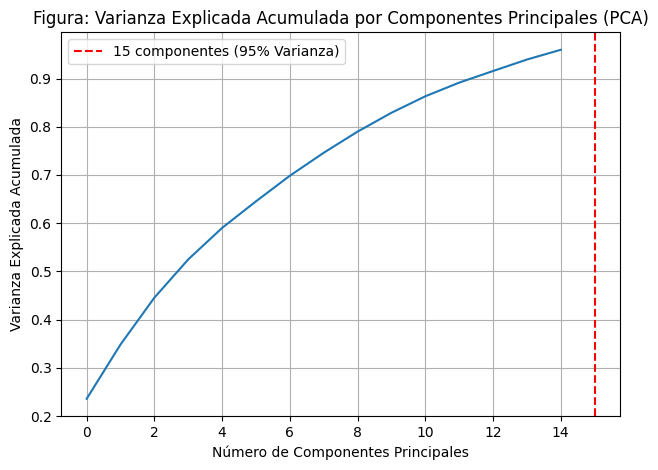

Datos de entrenamiento/validación transformados por PCA: (8000, 15)
Datos de prueba transformados por PCA: (2000, 15)

Nuevo entrenamiento de Logistic Regression con PCA
Fitting 5 folds for each of 6 candidates, totalling 30 fits
  Mejor F1-Score CV para Logistic Regression (PCA): 1.0000
  F1-Score en Test para Logistic Regression (PCA): 1.0000
  ROC AUC en Test para Logistic Regression (PCA): 1.0000

Nuevo entrenamiento de K-Nearest Neighbors con PCA
Fitting 5 folds for each of 12 candidates, totalling 60 fits
  Mejor F1-Score CV para K-Nearest Neighbors (PCA): 1.0000
  F1-Score en Test para K-Nearest Neighbors (PCA): 1.0000
  ROC AUC en Test para K-Nearest Neighbors (PCA): 1.0000


In [35]:
# debido a que PCA es sensible se aplica un escalado a la escalamiento de las caraacteristicas
scaler_pca = StandardScaler()
X_train_val_scaled_for_pca = scaler_pca.fit_transform(X_train_val)
X_test_scaled_for_pca = scaler_pca.transform(X_test)

# capturaremos el 95% de la varianza explicada
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train_val_scaled_for_pca) # Ajustar PCA solo en los datos de entrenamiento/validación escalados

n_components_pca = pca.n_components_
porcentaje = (1 - (n_components_pca / X_train_val.shape[1])) * 100
print(f"\nSe seleccionaron {n_components_pca} componentes principales para explicar el 95% de la varianza con una reducción de {porcentaje:.4f}")

# Visualizar la varianza explicada
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Figura: Varianza Explicada Acumulada por Componentes Principales (PCA)')
plt.grid(True)
plt.axvline(x=n_components_pca, color='r', linestyle='--', label=f'{n_components_pca} componentes (95% Varianza)')
plt.legend()
plt.tight_layout()
plt.show()

# Transformar los datos a los nuevos componentes principales
X_train_val_pca = pca.transform(X_train_val_scaled_for_pca)
X_test_pca = pca.transform(X_test_scaled_for_pca)

print(f"Datos de entrenamiento/validación transformados por PCA: {X_train_val_pca.shape}")
print(f"Datos de prueba transformados por PCA: {X_test_pca.shape}")

# Re-evaluar los 2 mejores modelos con los componentes PCA
pca_test_resultado = []

for model_name in top_2_models_names:
    print(f"\nNuevo entrenamiento de {model_name} con PCA")

    # obtener la configuracion original del modelo
    model_config = models_params[model_name]

    # crear un nuevo pipeline identico al original pero con la ejecucion del PCA
    pipeline_pca = ImbPipeline([
      ('scaler', StandardScaler()),
      ('pca', PCA(n_components=n_components_pca, random_state=42)),
      ('smote', SMOTE(random_state=42)),
      ('classifier', clone(model_config['model']))
    ])


    grid_search_pca = GridSearchCV(
      estimator=pipeline_pca,
      param_grid=model_config['param_grid'], # Usar los mismos de hiperparametros
      cv=stratified_kfold,
      scoring='f1',
      n_jobs=-1,
      verbose=1,
      return_train_score=True
    )

    # Entrenar el modelo con los datos originales
    grid_search_pca.fit(X_train_val, y_train_val)

    # Evaluar en el conjunto de prueba final
    y_pred_pca = grid_search_pca.best_estimator_.predict(X_test)
    y_proba_pca = grid_search_pca.best_estimator_.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_pca)
    prec = precision_score(y_test, y_pred_pca)
    rec = recall_score(y_test, y_pred_pca)
    f1 = f1_score(y_test, y_pred_pca)
    roc_auc = roc_auc_score(y_test, y_proba_pca)

    pca_test_resultado.append({
        'Model': model_name,
        'Method': 'PCA',
        'Reduction_Perc': porcentaje,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred_pca),
        'Best Params': grid_search_pca.best_params_,
        'Best CV F1': grid_search_pca.best_score_
    })

    print(f"  Mejor F1-Score CV para {model_name} (PCA): {grid_search_pca.best_score_:.4f}")
    print(f"  F1-Score en Test para {model_name} (PCA): {f1:.4f}")
    print(f"  ROC AUC en Test para {model_name} (PCA): {roc_auc:.4f}")

# Convertir a dataframe para acceso a la tabla final
pca_results_df = pd.DataFrame(pca_test_resultado).set_index('Model')

# Análisis y comparación final de todos los resultados


Tabla Comparativa de Desempeño (Original, SFS, PCA)
              Model  F1-Score  ROC AUC  Precision  Recall  Accuracy  Method  Reduction_Perc
K-Nearest Neighbors       1.0      1.0        1.0     1.0       1.0 control             0.0
K-Nearest Neighbors       1.0      1.0        1.0     1.0       1.0     SFS             0.0
K-Nearest Neighbors       1.0      1.0        1.0     1.0       1.0     PCA            25.0
Logistic Regression       1.0      1.0        1.0     1.0       1.0 control             0.0
Logistic Regression       1.0      1.0        1.0     1.0       1.0     SFS             0.0
Logistic Regression       1.0      1.0        1.0     1.0       1.0     PCA            25.0


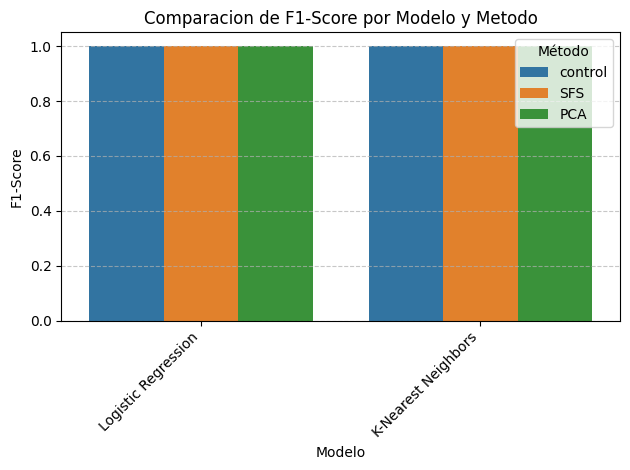

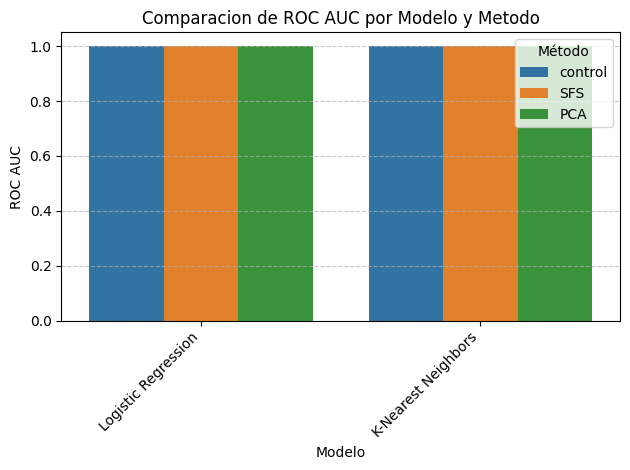

In [36]:
# Preparar los DataFrames para la unión
# Añadir una columna 'metodo' para usarlo como indicador de operacion
original_results = test_resultado_df.loc[top_2_models_names].copy() # Solo los 2 mejores modelos originales
original_results['Method'] = 'control'
original_results['Reduction_Perc'] = 0.0 # No hay reduccion de caracteriticas en el modelo original

sfs_results = sfs_resultados_df.copy()
pca_results = pca_results_df.copy()

# seleccionar solo las columnas de metricas que queremos comparar
cols_to_compare = ['F1-Score', 'ROC AUC', 'Precision', 'Recall', 'Accuracy', 'Method', 'Reduction_Perc']
df_original = original_results[cols_to_compare].reset_index().rename(columns={'index': 'Model'})
df_sfs = sfs_results[cols_to_compare].reset_index().rename(columns={'index': 'Model'})
df_pca = pca_results[cols_to_compare].reset_index().rename(columns={'index': 'Model'})


# concatenar todos los resultados para la comparación final
all_results_comparison = pd.concat([df_original, df_sfs, df_pca], ignore_index=True)

# ordenar para una mejor visualización
all_results_comparison_sorted = all_results_comparison.sort_values(by=['Model', 'F1-Score'], ascending=[True, False])

print("\nTabla Comparativa de Desempeño (Original, SFS, PCA)")
print(all_results_comparison_sorted.to_string(index=False))


# grafico de f1-Score por modelo y metodo
sns.barplot(data=all_results_comparison, x='Model', y='F1-Score', hue='Method')
plt.title('Comparacion de F1-Score por Modelo y Metodo')
plt.xlabel('Modelo')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método')
plt.tight_layout()
plt.show()

# grafico de roc auc por modelo y metodo
sns.barplot(data=all_results_comparison, x='Model', y='ROC AUC', hue='Method')
plt.title('Comparacion de ROC AUC por Modelo y Metodo')
plt.xlabel('Modelo')
plt.ylabel('ROC AUC')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método')
plt.tight_layout()
plt.show()

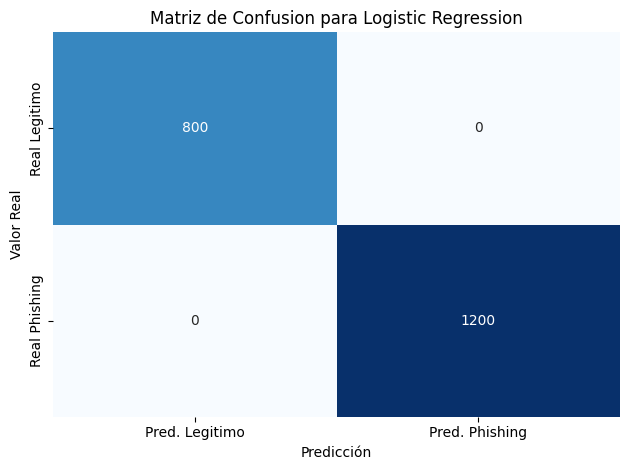

In [37]:
sns.heatmap(sfs_results['Confusion Matrix']['Logistic Regression'], annot=True, fmt='d', cmap='Blues', cbar=False,
  xticklabels=['Pred. Legitimo', 'Pred. Phishing'],
  yticklabels=['Real Legitimo', 'Real Phishing'])
plt.title('Matriz de Confusion para Logistic Regression')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

# Análisis de separabilidad

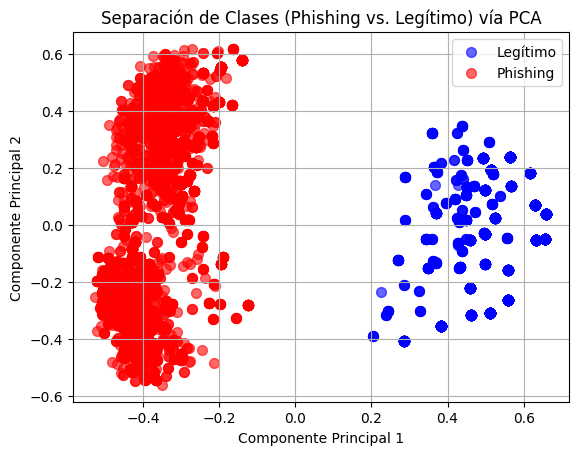

[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=distance; total time=   0.0s
[CV] END classifier__metric=manhattan, classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__metric=manhattan, classifier__n_neighbors=3, classifier__weights=distance; total time=   0.1s
[CV] END classifier__metric=manhattan, cla

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_data = X_train_val.values # Usamos el DataFrame creado después del fit/transform

pca = PCA(n_components=2)
components = pca.fit_transform(X_data)
pca_df = pd.DataFrame(data = components, columns = ['Componente_1', 'Componente_2'])

pca_df['label'] = y_train_val

for target, color in zip([0, 1], ['blue', 'red']):
    indicesToKeep = pca_df['label'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'Componente_1'],
                pca_df.loc[indicesToKeep, 'Componente_2'],
                c = color,
                s = 50,
                alpha = 0.6)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Separación de Clases (Phishing vs. Legítimo) vía PCA')
plt.legend(['Legítimo', 'Phishing'])
plt.grid(True)
plt.show()